## Exploring the on-time performance data

### Contents

1. Overview of the datasource
1. Objective
1. An Introduction to time series forecasting
	* ARIMA (Autoregressive Integrated Moving Average Model)
1. Import and basic overview of a data sample
1. Prepare the full dataset
	* Examine the Data
	* Resample the data
	* Time bands
1. Decomposition
1. Stationarity
	* Differencing
	* Augmented Dickey-Fuller test - To determine stationarity
1. Choosing the model order
	* Auto Regressive model analysis
	* Estimate the Order of the AR Model - Partial Autocorrelation method 
	* Estimate the Order of the AR Model - Information Criteria methods AIC and BIC
	* Moving Average model analysis
	* Estimate the Order of the MA Model - Autocorrelation method 
1. Fitting and evaluating the model
	* Train the model with each combination of parameters
	* Plot the forecast of each model
1. Conclusion
1. Resources
1. Appendix

### Overview of the data source

I have chosen a dataset published by the US Department of Transport's Bureau of Transportation Statistics. 
The dataset contains data for non-stop US domestic flights by major operators; it provides information on taxi-out and taxi-in times, departure and arrival delays, departure and arrival airports, flight numbers, departure and arrival times (scheduled and actual), flight status (cancelled or diverted), flight time and distance.

Link: https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236

### Objective 

The objective is to explore the On-Time Performance dataset and gain insight into Taxi Times. We have a customer driven requirement for information in this area, perhaps the insight discovered in this document could be used on private customer data, not in the public domain. The customer requirement is; for a given Departure Airport and month, forecast the taxi time per hour of the day. i.e. for next Month for JFK show me a forcast of the Taxi Out Time in minutes at time band 10am-11am, they would also like to know the forecast time for the month in general regardless of time of day.

The Taxi Out Time is the time in minutes between the departure time (when the aircraft leaves the gate), to take off (when the wheels leave the runway). Operators like to leave the gate on time as much as possible as this is the time that gets counted for delay purposes; sometimes an aircraft will leave the gate on time, then wait near the runway for an extended period of time, rather than the wait being at the gate itself mitigating a departure delay. However increased taxi-times cause cost in the form of fuel burn and a reduction in customer satisfaction.

### An Introduction to time series forecasting
The task at hand is one of time series forecasting; time series data is a set of data points collected at time intervals. Past points in time for a given observation can be analyzed to forecast future values, data can also be analysed more holistically to learn about the underlying processes generating it. A time series problem is different from a regular regression problem in a number of ways, the two main differences are:

* The basic assumption of a linear regression model is that the variables are independent of one another. However, a time series problem is dependent on a time component.
* Time Series data often has some form of seasonality as well as an increasing or decreasing trend, i.e. variation specific to a particular period in time. For example, Ice cream sales in the summer months will typically be higher than sales in winter.

#### ARIMA (Autoregressive Integrated Moving Average Model)
I will explore the idea of using an ARIMA model for forecasting; an ARIMA model is a popular model for time series analysis and forecasting. When the model is used, a degree of differencing is applied to make the data stationary (to remove trend and seasonality that may negatively affect a regression model), a linear regression model is then created using specfified parameters. 

The model is made up of 3 key aspects; AutoRegressive, Integrated and Moving Average. Which are simply described as: 

* AR: Autoregression - A model that uses the relationship between an observation at a point in time and one or more dependant observation(s) at previous time lag(s). 
* I: Integrated - Differencing is used to eliminate trend and seasonality, making it stationary. 
* MA: Moving Average - A model that uses the residual error from a moving average model applied to an observation and lagged observations.

The model takes 3 parameters: ARIMA(p,d,q) one for each key aspect of the model which control how the model operates. These are defined as:

* p: The number of lag observations included in the model, also called the lag order.
* d: The number of times that the raw observations are differenced, also called the degree of differencing.
* q: The size of the moving average window, also called the order of moving average.

It is designed to be used when the underlying process that generated the data is an ARIMA process, however if relevant, the model can be configured to perform the function of more simple AR, I, MA models or a ARMA combination model. If any of the p,d or q parameters are assigned a value of 0, that aspect is deactivated.

### Import and basic overview of a data sample
I have some prior knowledge of Python so I will be using this language to explore the data. 
The website containing the source data only provides monthly downloads; because I will need to explore data from different months, I downloaded several files from the website. Due to the large size of each file, I will explore one file to begin with, get a feel for the data contained and decide if there is any information I can throw away before looking at several months data. 
First I will import pandas and make one months data available as a dataframe using the read_csv method:

In [46]:
#Import the required packages

# Data manipulation
import pandas as pd
import numpy as np

# Filehandling 
import os

# Plotting
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8.0, 5.0]

# Statsmodels libraries
import statsmodels.api as sm  
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [47]:
firstfile = 'C:/Users/durandt/Documents/Aston/Data Sets/On-Time Data/csv/On_Time_On_Time_Performance_2017_1.csv'
df1 = pd.read_csv(firstfile, low_memory=False) 
df1.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,Carrier,TailNum,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2017,1,1,17,2,2017-01-17,AA,19805,AA,N583AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017,1,1,18,3,2017-01-18,AA,19805,AA,N544AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017,1,1,19,4,2017-01-19,AA,19805,AA,N553AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017,1,1,20,5,2017-01-20,AA,19805,AA,N191AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017,1,1,21,6,2017-01-21,AA,19805,AA,N170AA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
# NULLs
info=pd.DataFrame(df1.isnull().sum()).T.rename(index={0:'# NULL'})
info=info.append(pd.DataFrame(df1.isnull().sum()/df1.shape[0]*100).T.rename(index={0:'% NULL'}))
info=info.append(pd.DataFrame(df1.dtypes).T.rename(index={0:'type'}))
AllNull = info.T
AllNull = AllNull[AllNull['% NULL'] == 100]
print("Columns with all nulls:")
list(AllNull.index)

Columns with all nulls:


['Div3Airport',
 'Div3AirportID',
 'Div3AirportSeqID',
 'Div3WheelsOn',
 'Div3TotalGTime',
 'Div3LongestGTime',
 'Div3WheelsOff',
 'Div3TailNum',
 'Div4Airport',
 'Div4AirportID',
 'Div4AirportSeqID',
 'Div4WheelsOn',
 'Div4TotalGTime',
 'Div4LongestGTime',
 'Div4WheelsOff',
 'Div4TailNum',
 'Div5Airport',
 'Div5AirportID',
 'Div5AirportSeqID',
 'Div5WheelsOn',
 'Div5TotalGTime',
 'Div5LongestGTime',
 'Div5WheelsOff',
 'Div5TailNum',
 'Unnamed: 109']

Accompanying the data is a html readme file containing the description for each column, I have formatted this into the table and added to the appendix for reference

Based on the readme file information about the data, the columns containing all null values(above) and the problem I'm looking to resolve, the following are potentially useful for an overview of the dataset:
Year, Quarter, Month, DayofMonth, DayOfWeek, FlightDate, UniqueCarrier, Origin, Dest, CRSDepTime, DepTime, DepDelay, TaxiOut, WheelsOff, Cancelled, Diverted

In [49]:
# Subset the data
df1 = df1[['Year','Quarter','Month','DayofMonth','DayOfWeek','FlightDate','UniqueCarrier','Origin','Dest','CRSDepTime','DepTime'
           ,'DepDelay','TaxiOut','WheelsOff','Cancelled','Diverted']]

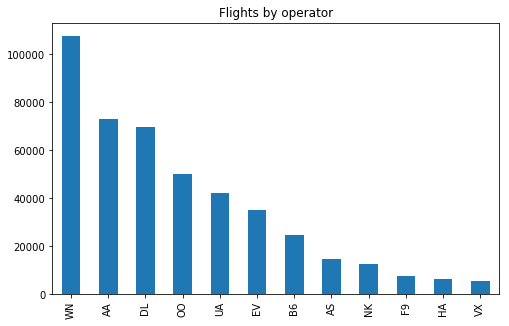

In [50]:
# Show the count of flights per Operator
df1['UniqueCarrier'].value_counts().plot(kind='bar', title='Flights by operator')
plt.show()

In [51]:
print('Top 10 Origins')
df1.groupby('Origin').agg({'Origin':'count'}).sort_values('Origin',
ascending = False).rename(columns = {'Origin' : 'Count'}).head(10).transpose()

Top 10 Origins


Origin,ATL,ORD,LAX,DEN,DFW,SFO,PHX,LAS,MCO,IAH
Count,30138,18782,17314,17030,15304,13283,13257,12487,11007,10805


In [52]:
print('Top 10 Origins for American Airlines')
df1[df1['UniqueCarrier']=='AA'].groupby('Origin').agg({'Origin':'count'}).sort_values('Origin',
ascending = False).rename(columns = {'Origin' : 'Count'}).head(10).transpose()

Top 10 Origins for American Airlines


Origin,DFW,CLT,ORD,PHX,MIA,PHL,LAX,DCA,BOS,LGA
Count,11386,7927,4864,4716,4497,3482,3132,2074,1968,1815


In order to simplify the problem and because of the high computational time on a large amount of data, for now I will look at American Airlines and JFK Airport. I will also remove any cancelled flights. 

In [53]:
df1 = df1[(df1.UniqueCarrier =='AA') & (df1.Origin =='JFK') & (df1.Cancelled == 0.0)]

I will now deal with the temporal munging of the data. Because there are multiple flights per day I suspect there will be seasonality based on the time of day each flight departs, as each Airport has its own Peak and OffPeak times of day. 

In [54]:
print("For example - Number of Flights on 01/01/2017: " 
+ df1[(df1.FlightDate =='2017-01-01')]['DepTime'].count().astype(str))


For example - Number of Flights on 01/01/2017: 54


I bin the data into hourly time bands and examine the counts per time band:

In [55]:
# Create a function to retain only the hour portion of the timeband
def converttimeband(time):
    if pd.isnull(time):
        return np.nan
    elif len(time) > 5:
        timeband = time[0:2]
    elif len(time) > 4:
        timeband = "0" + time[0:1]
    else:
        timeband = '00'
    return(timeband)      

# Create the Timeband column from Departure Time converted to a string
df1['Timeband'] = df1['DepTime'].astype(str)

# Apply the function to the new Timeband column
df1['Timeband'] = df1['Timeband'].apply(converttimeband)

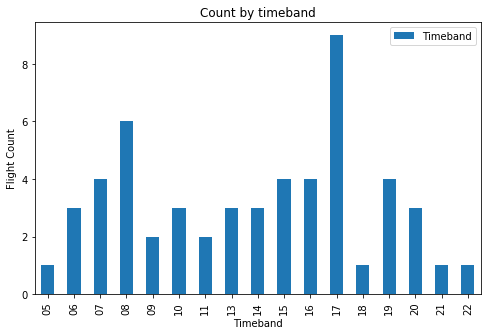

In [56]:
# Show the count of flights departing in each Timeband
df1[(df1.FlightDate =='2017-01-01')].groupby('Timeband').agg({'Timeband':'count'}).plot(kind='bar',sort_columns = 'Timeband', title='Count by timeband')
plt.ylabel("Flight Count")
plt.legend(loc='best')
plt.show()

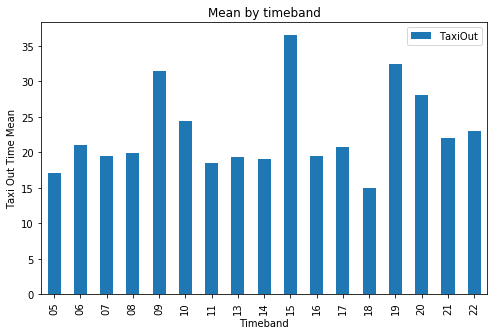

In [57]:
# Show the mean of flights departing in each Timeband
df1[(df1.FlightDate =='2017-01-01')].groupby('Timeband').agg({'TaxiOut':'mean'}).plot(kind='bar',sort_columns = 'Timeband', title='Mean by timeband')
plt.ylabel("Taxi Out Time Mean")
plt.legend(loc='best')
plt.show()

We can see from the flight counts chart that there are definate Peak and OffPeak times. The mean of the Taxi time varies a reasonable amount accross Timebands. A minute extra here or there can add up to tonnes of extra fuel being consumed over all.
In order to produce a monthly prediction I am going to have to resample the data; the question is... should I resample all values in a month, or should I use feature engineering to pivot the TaxiOut times into 24 features, one per Timeband then resample to monthly TaxiOut times.  
To begin with I will disregard timeband, and resample all values to a monthly mean.

### Prepare the full dataset
Now I have a brief understanding of a portion of the data I can import the full dataset in a cutdown, memory friendly way.
As I'm looking to forecast future months TaxiOut times based on previous months TaxiOut values I can cut down the amount of data from the start. I created a new FlightDate column from the 'Year','Month' and 'DayofMonth' columns, as the source files have different date formats for the FlightDate column, e.g. 2016-01-01 and 01/02/2016. The FlightDate and DepTime are then used to form a datetime component. I will keep the timeband information and also use the categorical variables to trim down the dataset to the Amerian Airlines operator and JFK Airport.

In [13]:
# Combine all files with the cutdown list of columns
datadir = 'C:/Users/durandt/Documents/Aston/Data Sets/On-Time Data/csv/'
filelist = os.listdir(datadir)
dfpart = [pd.read_csv(datadir + file, usecols = ['Year','Quarter','Month','DayofMonth','UniqueCarrier','Origin','DepTime','TaxiOut','Cancelled']) for file in filelist]
df = pd.concat(dfpart,ignore_index=True)

# Filter the data to AA and JFK
df = df[(df.UniqueCarrier =='AA') & (df.Origin =='JFK') & (df.Cancelled == 0.0)]

# Create a new FlightDate from the 'Year','Month','DayofMonth' as there are different formats of FlightDate across source files
df['FlightDate'] = df['Year'].astype(str) + "-" + df['Month'].astype(str) + "-" + df['DayofMonth'].astype(str)

# Create the Timeband column from Departure Time converted to a string
df['Timeband'] = df['DepTime'].astype(str)

# Apply the function to the new Timeband column
df['Timeband'] = df['Timeband'].apply(converttimeband)

# Remove the category columns that are no longer relavent
df = df[['FlightDate','DepTime','TaxiOut','Timeband']]

In [14]:
# Create the Time from DepTime converted to a string
df['Time'] = df['DepTime'].astype(str)

# Create a function to convert to time
def converttime(time):
    if pd.isnull(time):
        return "00:00"
    if time == "2400.0":
        return "00:00"
    elif len(time) > 5:
        hrpart = time[0:2]
        minpart = time[2:4]
    elif len(time) > 4:
        hrpart = "0" + time[0:1]
        minpart = time[1:3]
    elif len(time) > 3:
        hrpart = "00"
        minpart = time[0:2]
    else:
        hrpart = "00"
        minpart = "0" + time[0:1] 
    convtime = hrpart[0:2] + ":" + minpart[0:2] 
    return(convtime)      

# Apply the function to the Time column
df['Time'] = df['Time'].apply(converttime)

# Combine the FlightDate with the formatted Time Column in a specfic format
df['FlightDateTime'] = pd.to_datetime(df['FlightDate'] + ' ' + df['Time'], format='%Y-%m-%d %H:%M')

# Remove the columns that are no longer required
df = df[['FlightDateTime','TaxiOut','Timeband']]

# Re-index the dataframe with the FlightDateTime
df.set_index('FlightDateTime', inplace=True)

In [15]:
# I can now save this combined file to a new csv to save me time in future if required.
#datadir = 'C:/Users/durandt/Documents/Aston/Data Sets/On-Time Data/'
#df.to_csv(datadir + "Data_Fullset.csv",index=False,)

#### Examine the Data
First of all I will visualize the data to further understand it and get an idea of the type of model I should use. Through this visualisation stage I hope to discover if there is an overall trend in the data and if there are there any seasonal trends. This is important when deciding which type of model to use and the required parameters for the model. 

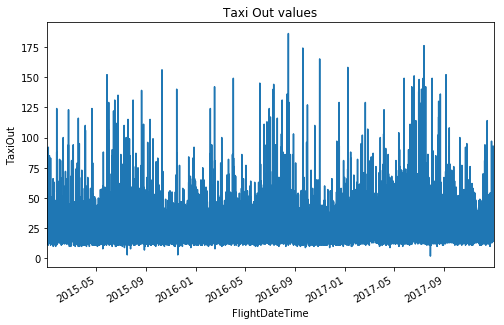

In [60]:
df['TaxiOut'].plot(title = 'Taxi Out values')
plt.ylabel("TaxiOut")
plt.xlabel("FlightDateTime")
plt.show()

In [17]:
df['TaxiOut'].describe()

count    51801.000000
mean        26.354800
std         13.298175
min          2.000000
25%         18.000000
50%         23.000000
75%         31.000000
max        186.000000
Name: TaxiOut, dtype: float64

In [18]:
# NULLs
info=pd.DataFrame(df.isnull().sum()).T.rename(index={0:'# NULL'})
info=info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'% NULL'}))
info=info.append(pd.DataFrame(df.dtypes).T.rename(index={0:'type'}))
info

,TaxiOut,Timeband
# NULL,0,0
% NULL,0,0
type,float64,object


#### Resample the data
Now I have some statisical awareness of the data and know that interpolation is not required at this stage, I can move on to resampling the data.
As I am using per flight data (more frequent than daily) there is too much variation to determine trends; I will therefore resample the data using the mean. If I was looking at stock prices I may wish to use the last value in the month, I think for this purpose the mean is the most applicable. The resample function in python is similar to the rolling function but uses the date component instead of the frequency which I find quite convenient. 

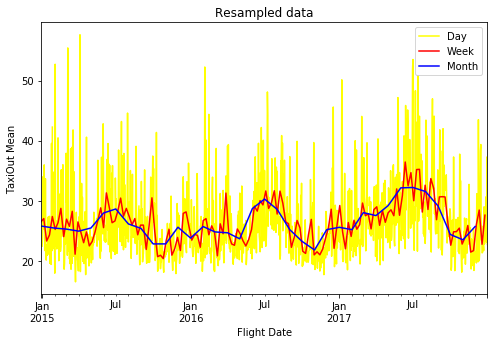

In [61]:
dfd = df[['TaxiOut']].resample("D").mean()
dfd['TaxiOut'].plot(color = "yellow", label = "Day")

dfw = df[['TaxiOut']].resample("W").mean()
dfw['TaxiOut'].plot(color = "red", label = "Week")

dfm = df[['TaxiOut']].resample("M").mean()
dfm['TaxiOut'].plot(color = "blue", label = "Month")

plt.ylabel("TaxiOut Mean")
plt.xlabel("Flight Date")
plt.title("Resampled data")
plt.legend(loc='best')
plt.show()

We can see from the above plot that there is very slight long-term upward trend, which is to be expected as the number of flights each year in general is increasing; this may be more aparent when looking at a longer period of time. There is an annual seasonality with the summer months having a greater TaxiOut time than the winter. There is also weekly and daily fluctuations which could be based on a number of factors including weather, airline operational factors and news events etc. 
As I am trying to predict the Taxi Out Time for future months I will take the monthly resampled data forward to the next steps in the process.

#### Time bands

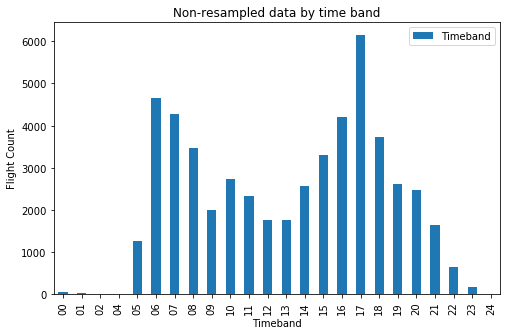

In [62]:
# Show the count of flights departing in each Timeband
df.groupby('Timeband').agg({'Timeband':'count'}).plot(kind='bar',sort_columns = 'Timeband', title = 'Non-resampled data by time band')
plt.ylabel("Flight Count")
plt.legend(loc='best')
plt.show()

Below I have plotted the monthly resampled data filtered by four example time bands.

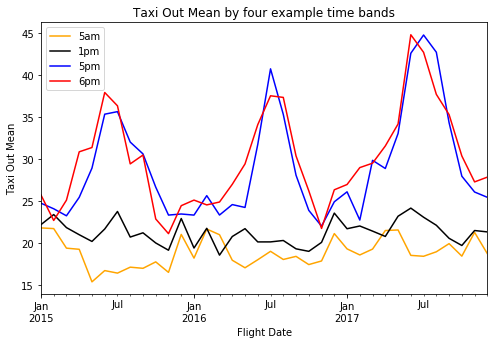

In [63]:
plt.rcParams['figure.figsize'] = [8.0, 5.0]
dfw5am = df[df['Timeband'] == '05'][['TaxiOut']].resample("M").mean()
dfw5am['TaxiOut'].plot(color = "orange", label = "5am")

dfd1pm = df[df['Timeband'] == '13'][['TaxiOut']].resample("M").mean()
dfd1pm['TaxiOut'].plot(color = "black", label = "1pm")

dfm5pm = df[df['Timeband'] == '17'][['TaxiOut']].resample("M").mean()
dfm5pm['TaxiOut'].plot(color = "blue", label = "5pm")

dfm6pm = df[df['Timeband'] == '18'][['TaxiOut']].resample("M").mean()
dfm6pm['TaxiOut'].plot(color = "red", label = "6pm")

plt.ylabel("Taxi Out Mean")
plt.xlabel("Flight Date")
plt.title("Taxi Out Mean by four example time bands")
plt.legend(loc='best')
plt.show()

The Timebands at peak times, where most flights occur; can be thought of as principal components, contributing much more to the variation than the offpeak times. I will take forward the monthly mean values for now.

### Decomposition
According to Wikipedia, decomposition in time series is *a statistical task that deconstructs a time series into several components, each representing one of the underlying categories of patterns."*
https://en.wikipedia.org/wiki/Decomposition_of_time_series

Below I use the seasonal_decompose tool from the statsmodels library; this is a useful tool to get a quick graphical representation of a naive decomposition. According to the documentation on seasonal_decompose: "The seasonal component is first removed by applying a convolution filter to the data. The average of this smoothed series for each period is the returned seasonal component." 
http://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html




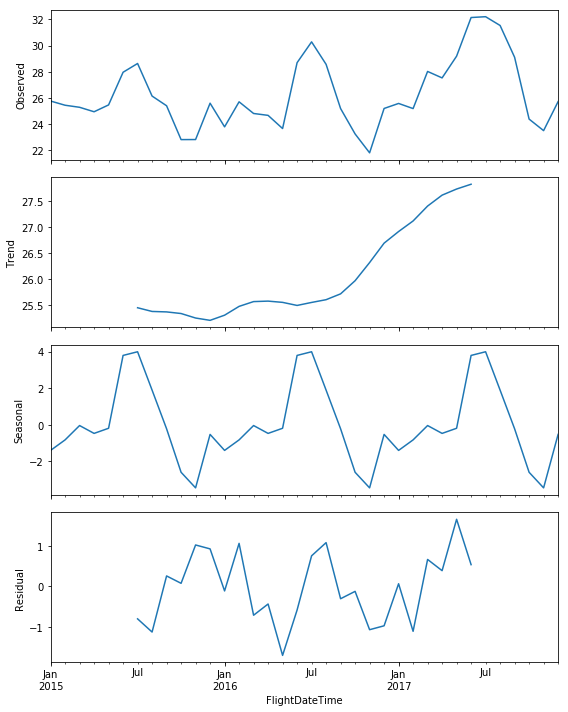

In [22]:
decomposition = seasonal_decompose(dfm.TaxiOut) 
plt.rcParams['figure.figsize'] = [8.0, 10.0]
fig = decomposition.plot()  
plt.show()

### Stationarity 
In order for time series to be stationary; the mean, variance and covariance of the series should not be a function of time, i.e. its statistical properties should remain constant over time.
If a process is not stationary it becomes difficult to model; modelling involves estimating a parameter and if a parameter is different over time then this means there are too many parameters to estimate.
For example; linear regression models assume that all observations are independent of each other, however, with time series data, observations are time dependent. By Stationarizing data, regression methods can be applied to the time dependent variable.

I use rolling statitistics to extract the trend element from the time series. We can see that the red line below is very similar to the trend line using the seasonal_decompose method.

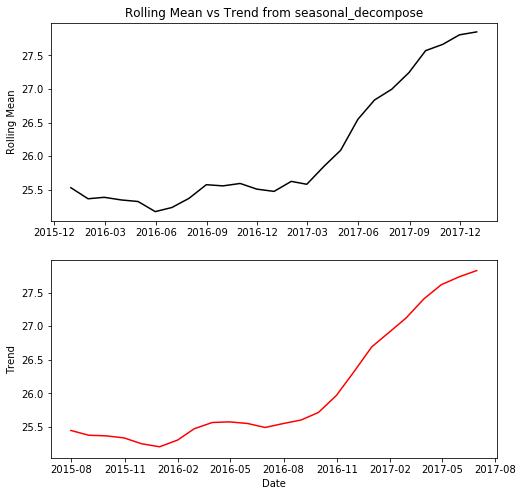

In [23]:
#Calculate rolling mean
rolmean12 = dfm.rolling(window=12).mean()

# Create two subplots sharing y axis
plt.rcParams['figure.figsize'] = [8.0, 8.0]
fig, (ax1, ax2) = plt.subplots(2, sharey=True)

ax1.plot(rolmean12, color = 'black')
ax1.set(title='Rolling Mean vs Trend from seasonal_decompose', ylabel='Rolling Mean')

ax2.plot(decomposition.trend, color = 'red')
ax2.set(xlabel='Date', ylabel='Trend')

plt.show()

#### Differencing
In order to get the residual data i.e. with the seasonal trend removed, I can take differences with a lag corresponding to the periodicity. I have used a differencing of 12 as I am looking at monthly resampled data. We can see that the red "differenced" line below is similar to the black "residual" line using the seasonal_decompose method, they are not exactly the same as the seasonal_difference function uses a different calculation method, but we can see the resemblance here. 
However if I use a difference of 1 it produces a much different result, it also produces an autocorrelation plot with none of the values outside of the 95% confidence area.

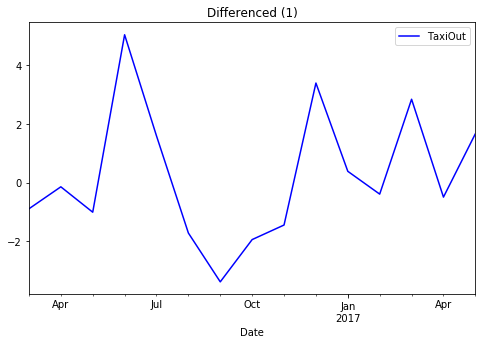

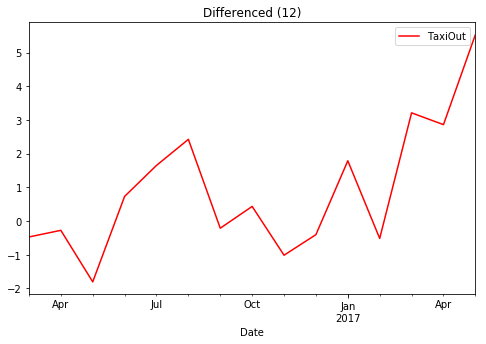

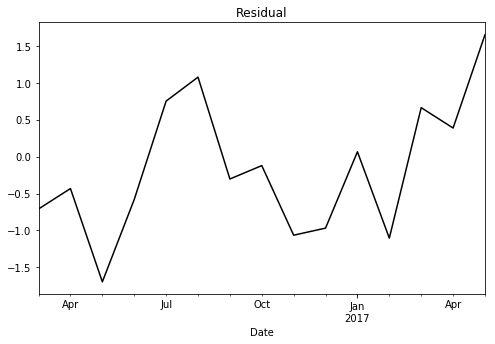

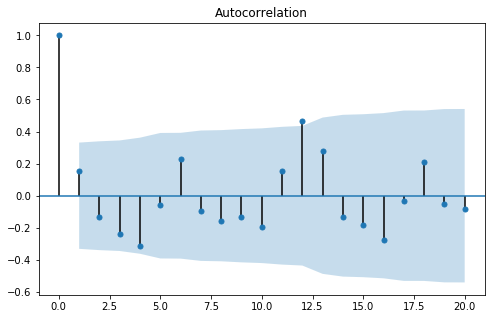

In [24]:
# Difference the monthly data
dfms = dfm.diff(1)
dfms12 = dfm.diff(12)
# Drop null values
dfms = dfms.dropna()
dfms12 = dfms12.dropna()

plt.rcParams['figure.figsize'] = [8.0, 5.0]

# Plot the differenced values
dfms['2016-03-01':'2017-06-01'].plot(color = "blue", title ="Differenced (1)")
plt.xlabel("Date")
plt.show()

# Plot the 12 differenced values
dfms12['2016-03-01':'2017-06-01'].plot(color = "red", title = "Differenced (12)")
plt.xlabel("Date")
plt.show()

#Plot the residual element of the seasonal_decomposition function
decomposition.resid['2016-03-01':'2017-06-01'].plot(color = "black", title = "Residual")
plt.xlabel("Date")
plt.show()

# plot the autocorrelation of the differenced 1 values
plot_acf(dfms.TaxiOut, lags=20)

According to the above the differenced(1) data now looks more stationary and is a better result than the 12 differenced value; the autocorrelation function is now showing all previous lags are within the 95% confidence window, with the 12th lagged value just outside the confidence interval perhaps hinting at the annual seasonality being present.

#### Augmented Dickey-Fuller test - To determine stationarity
One way to statistically determine the stationarity of time series data is to use the Augmented Dickey-Fuller test. 
I will use the adfuller function from the statsmodels library. The statsmodels documentation (http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) defines the function as:

*"The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root.
The p-values are obtained through regression surface approximation from MacKinnon 1994, but using the updated 2010 tables. If the p-value is close to significant, then the critical values should be used to judge whether to reject the null."*

I will test the original and differenced data to see if they are stationary.

In [25]:
# Create function to run the Dickey-Fuller test
def TestAdfuller(ts, cutoff = 0.01):
    ts_test = adfuller(ts, autolag = 'AIC')
    ts_test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])   
    print("p-value = ", ts_test[1])  
    print("cutoff = ", cutoff,"\n") 

print("** Original data **")
TestAdfuller(dfm['TaxiOut'])

print("** Difference of lag 1 **")
TestAdfuller(dfms['TaxiOut'])

print("** Difference of lag 12 **")
TestAdfuller(dfms12['TaxiOut'])


** Original data **
p-value =  0.0158231175438
cutoff =  0.01 

** Difference of lag 1 **
p-value =  0.00143640489155
cutoff =  0.01 

** Difference of lag 12 **
p-value =  0.0412516892753
cutoff =  0.01 



We can see that only the data differenced by one lag has strong evidence against the null hypothesis, meaning the data has no unit root, and is stationary
The original and data differenced by 12 has weak evidence against the null hypothesis, meaning it is non-stationary.

### Choosing the model order

Before fitting any models I first need to seperate the data into a test and training set as not to overfit the model. I will use the first two years for training and the third year for testing the forecast.

In [26]:
# Split the data into train and test sets
train = dfm[0:24]
test = dfm[24:]

#### Auto Regressive model analysis
An AR model of order 1 can be simply described as; a mean, plus a fraction (&Phi;) of the previous lagged value, plus noise. 

Higher orders of models take into account additional &Phi; values, for example; 

##### RA(1)
Rt = μ + ϕRt-1 + εt
##### RA(2)
Rt = μ + ϕ1Rt-1 + ϕ2Rt-2 + εt
##### RA(3)
Rt = μ + ϕ1Rt-1 + ϕ2Rt-2 + ϕ3Rt-3 + εt

Each value of &Phi; needs to be between -1 and 1 for stationarity.

If &Phi; is negative this implies mean reversion; i,e. if the value at T<sub>-1</sub> is positive, then a negative &Phi; means that the value at T0 would be negative.
If &Phi; is positive this implies trend following (momentum); i,e. if the value at T<sub>-1</sub> is positive, then a positive &Phi; means that the value at T0 would be positive.

Using an autocorrelation function, the value decreases exponentially at a rate of &Phi;, e.g. if &Phi; = 0.9, the lag 1 autocorrelation is 0.9, the lag 2 autocorrelation is 0.9<sup>2</sup>, the lag 3 autocorrelation is 0.9<sup>3</sup>. etc. If &Phi; is negative then the sign of the autocorrelation values are inverted at each lag.

#### Estimate the Order of the AR Model - Partial Autocorrelation method 
The order of the model (p) needs to be determined before running the model.
The Partial Autocorrelation Function (PACF) is a useful tool to identify this value. 
The results are interpretted as follows: For a p value of 1, the PACF should have a significant lag-1 value, and values close to zero after that. For a p value of 2, the PACF result should have significant lag 1 and lag 2 values, and values close to zero after that.

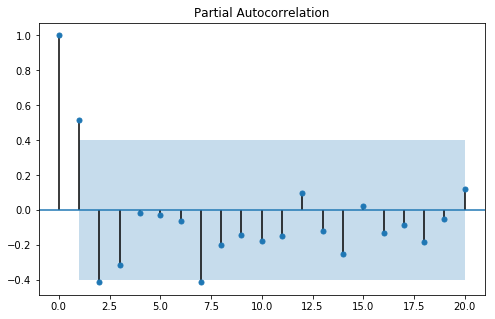

In [27]:
# Plot pacf
plt.rcParams['figure.figsize'] = [8.0, 5.0]
plot_pacf(train.TaxiOut, lags=20)

We can see from the above plots that a good starting point for model selection would be an AR(2) model. There is also some autocorrelation at lag 7 which may be useful to try later.

#### Estimate the Order of the AR Model - Information Criteria methods AIC and BIC
Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC) are two measures used to compute the goodness of fit using estimated parameters. A penalty function is also applied on the number of parameters.

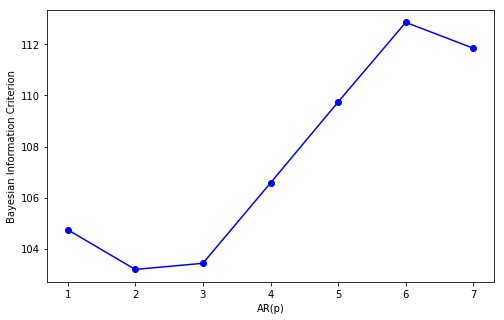

In [64]:
# Fit the data to an AR model with a p value between 0 and 7 and store the resultant BIC
plt.rcParams['figure.figsize'] = [8.0, 5.0]
BIC = np.zeros(8)
for p in range(8):
    mod = ARIMA(train, order=(p,0,0))
    res = mod.fit()
# Save BIC    
    BIC[p] = res.bic
# Plot the BIC over p
plt.plot(range(1,8), BIC[1:8], marker='o', color = "blue")
plt.xlabel('AR(p)')
plt.ylabel('Bayesian Information Criterion')
plt.show()

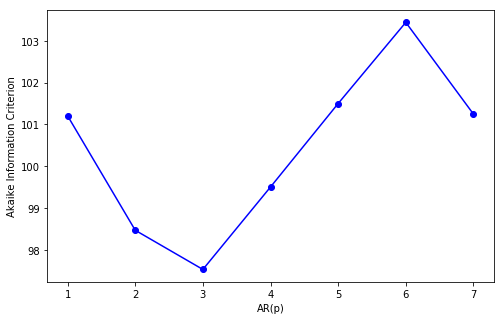

In [29]:
# Fit the data to an AR model with a p value between 0 and 7 and store the resultant AIC
plt.rcParams['figure.figsize'] = [8.0, 5.0]
AIC = np.zeros(8)
for p in range(8):
    mod = ARIMA(train, order=(p,0,0))
    res = mod.fit()
# Save AIC  
    AIC[p] = res.aic
# Plot the AIC over p
plt.plot(range(1,8), AIC[1:8], marker='o', color = "blue")
plt.xlabel('AR(p)')
plt.ylabel('Akaike Information Criterion')
plt.show()

We can see from the above plots that an AR(2) model has the lowest BIC, and an AR(3) model has the lowest AIC value; we can look at the difference between these two order choices later to see which is optimum.

#### Moving Average model analysis
An MA(1) model can be simply described as; a mean, plus noise plus a fraction (θ) of the previous lagged noise value.  Higher orders of models take into account additional θ values, if the value of θ is 0 then the generator of the data is white noise.
##### MA(1) model
Rt = μ + ϵt1 + θϵt-1

If θ is negative this implies mean reversion; i,e. if the value at T<sub>-1</sub> is positive, then a negative θ means that the value at T<sub>0</sub> would be negative.
If θ is positive this implies trend following (momentum); i,e. if the value at T<sub>-1</sub> is positive, then a positive θ means that the value at T<sub>0</sub> would be positive.

Using an autocorrelation function, unlike an AR(1) model, an MA(1) model will not have any (significant) values above 0 beyond lag 1, i.e. an MA(q) model has no autocorrelation beyond lag q. It is also worth noting that the lag 1 autocorrelation value for an MA(1) model is not θ, but θ/(1+θ²), if the value of θ is negative then the value at lag 1 would be -θ/(1+(-θ)²)

#### Estimate the Order of the MA Model - Autocorrelation method 
Correlation is used to compare two different observations, whereas autocorrelation is the correlation of a time series with a lagged copy of itself. 
If a time series has a negative autocorrelation it is known as mean reverting, and if it has positive autocorrelation it is known as trend following or that it has positive momentum. 
Autocorrelation can be used to estimate the q value of an MA model. I use the acf function from the statsmodels library below to  plot the results with the default confidence level of 95%.

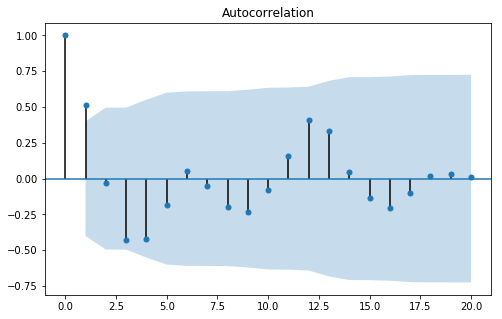

Autocorrelation of Taxi Out =  0.516517378653


In [30]:
# Plot the acf function
plt.rcParams['figure.figsize'] = [8.0, 5.0]
plot_acf(train.TaxiOut, lags=20)
plt.show()

autocorrelation = train['TaxiOut'].autocorr()
print("Autocorrelation of Taxi Out = ", autocorrelation)

We can see the seasonal element coming out around 12 lags, we can also conclude that there is some positive correlation to the 2nd lag value. The 1st lag value is the only one outside of the 95% confidence area (blue shaded area), meaning that only this value is significant, i.e. The lag value T<sub>-1</sub> is positively correlated to the value at T<sub>0</sub>. A value of 1 should be used for the MA model parameter q.

### Fitting and evaluating the model
Now we have explored each element of the ARIMA model and have some recomended parameter values, we can fit the model to the data and evaluate how each model performs. 
I will use the statsmodels library for my ARIMA model; the model is created as follows:
1. Create the model by calling ARIMA() and passing in the required p, d, and q parameters.
1. The model is trained by calling the fit() function.
1. Predictions are made by calling the predict() function and specifying the range or index of the time values to be predicted.

To evaluate the model I will examine the residuals, which should haven no patterns and be normally distributed. I can also use an ACF plots for the residuals; I would expect no significant values in the autocorrelation plot if the parameters are good. I will also visualy examine the prediction plot for each version of the model.

#### Train the model with each combination of parameters

In [31]:
# AR(2) model, turning off the I and MA components of the ARIMA model with 0 d and q values.
p = 2
d = 0
q = 0
mod200 = ARIMA(train, order=(p,d,q))
res200 = mod200.fit()

# AR(3) model to see how this compares to AR(2), turning off the I and MA components of the ARIMA model with 0 d and q values.
p = 3
d = 0
q = 0
mod300 = ARIMA(train, order=(p,d,q))
res300 = mod300.fit()

# ARIMA(2,1,0) I will now add a differencing of 1 to the AR(2) model
p = 2
d = 1
q = 0
mod210 = ARIMA(train, order=(p,d,q))
res210 = mod210.fit()

# ARIMA(3,1,0) I will now add a differencing of 1 to the AR(2) model
p = 3
d = 1
q = 0
mod310 = ARIMA(train, order=(p,d,q))
res310 = mod310.fit()

# MA(1) model, turning off the AR and I components of the ARIMA model with 0 value p and d values.
p = 0
d = 0
q = 1
mod001 = ARIMA(train, order=(p,d,q))
res001 = mod001.fit()

# ARIMA(0,1,1) I will now add a differencing of 1 to the MA(1) model
p = 0
d = 1
q = 1
mod011 = ARIMA(train, order=(p,d,q))
res011 = mod011.fit()

# ARIMA(2,1,1)
p = 2
d = 1
q = 1
mod211 = ARIMA(train, order=(p,d,q))
res211 = mod211.fit()

# ARIMA(3,1,1)
p = 3
d = 1
q = 1
mod311 = ARIMA(train, order=(p,d,q))
res311 = mod311.fit()

#### Plot the forecast of each model

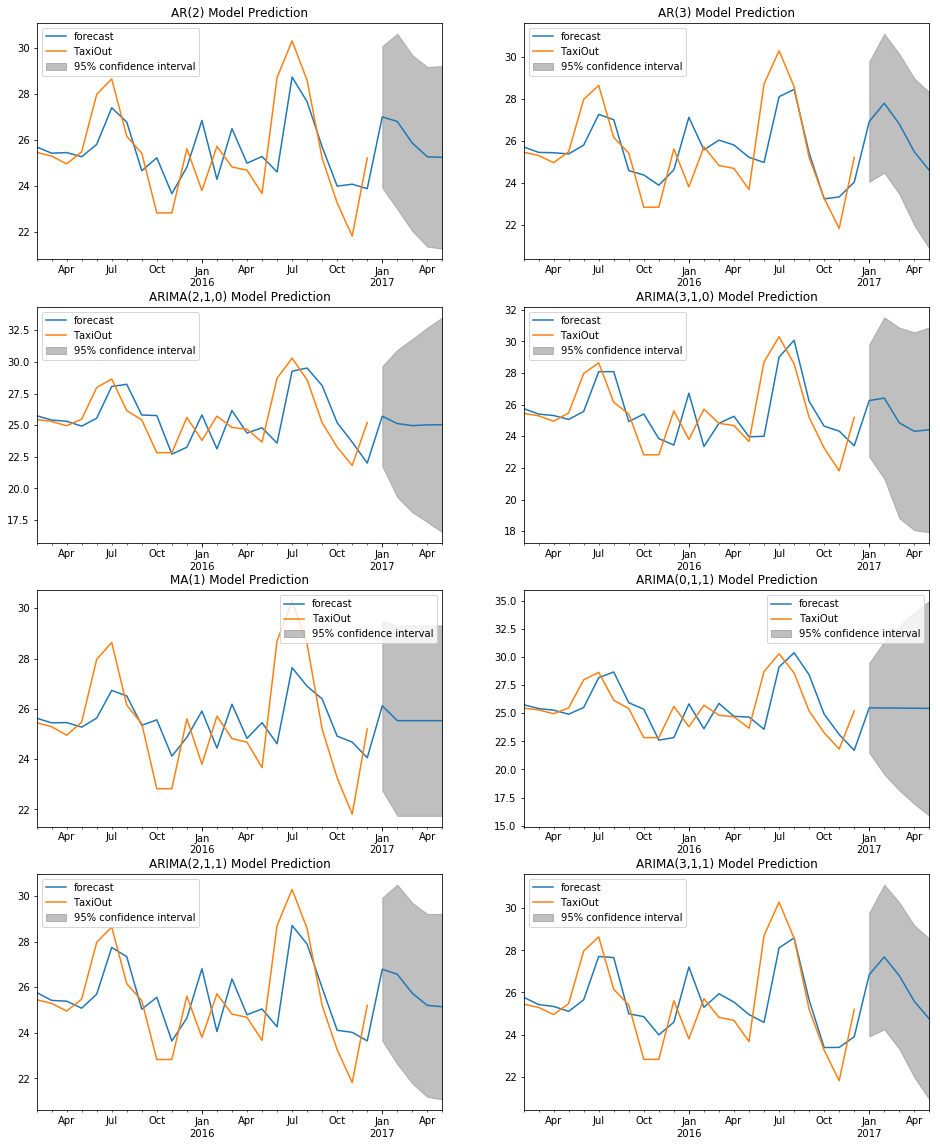

In [32]:
# Define the prediction start and end months
predstart = 1
predend = 28
plt.rcParams['figure.figsize'] = [16.0, 20.0]

ax1 = plt.subplot(4, 2, 1)
ax2 = plt.subplot(4, 2, 2)
ax3 = plt.subplot(4, 2, 3)
ax4 = plt.subplot(4, 2, 4)
ax5 = plt.subplot(4, 2, 5)
ax6 = plt.subplot(4, 2, 6)
ax7 = plt.subplot(4, 2, 7)
ax8 = plt.subplot(4, 2, 8)
# AR(2)
fig = res200.plot_predict(start=predstart, end=predend, ax = ax1)
ax1.set_title("AR(2) Model Prediction")

# AR(3)
res300.plot_predict(start=predstart, end=predend, ax = ax2)
ax2.set_title("AR(3) Model Prediction")

# ARIMA(2,1,0)
res210.plot_predict(start=predstart, end=predend, ax = ax3)
ax3.set_title("ARIMA(2,1,0) Model Prediction")

# ARIMA(3,1,0)
res310.plot_predict(start=predstart, end=predend, ax = ax4)
ax4.set_title("ARIMA(3,1,0) Model Prediction")
 
# MA(1)
res001.plot_predict(start=predstart, end=predend, ax = ax5)
ax5.set_title("MA(1) Model Prediction")

# ARIMA(0,1,1)
res011.plot_predict(start=predstart, end=predend, ax = ax6)
ax6.set_title("ARIMA(0,1,1) Model Prediction")

# ARIMA(2,1,1)
res211.plot_predict(start=predstart, end=predend, ax = ax7)
ax7.set_title("ARIMA(2,1,1) Model Prediction")

# ARIMA(3,1,1)
res311.plot_predict(start=predstart, end=predend, ax = ax8)
ax8.set_title("ARIMA(3,1,1) Model Prediction")
plt.show()

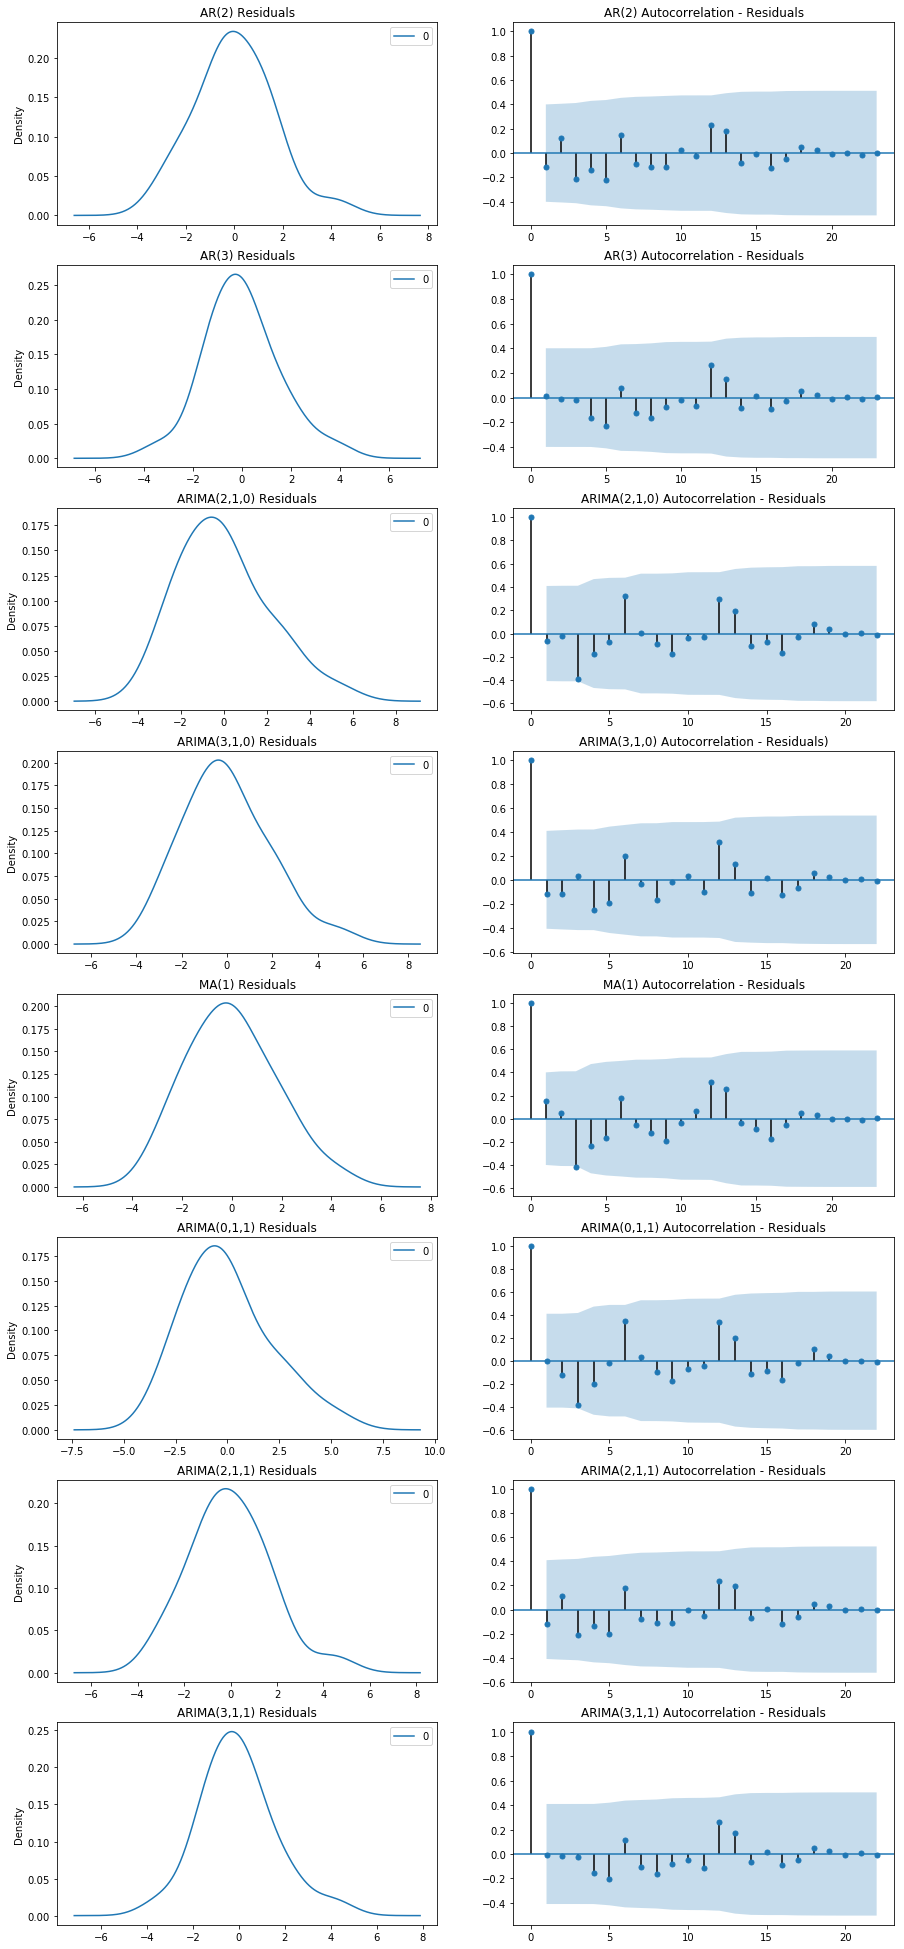

In [33]:
plt.rcParams['figure.figsize'] = [15.0, 35.0]
ax1 = plt.subplot(8, 2, 1)
ax2 = plt.subplot(8, 2, 2)
ax3 = plt.subplot(8, 2, 3)
ax4 = plt.subplot(8, 2, 4)
ax5 = plt.subplot(8, 2, 5)
ax6 = plt.subplot(8, 2, 6)
ax7 = plt.subplot(8, 2, 7)
ax8 = plt.subplot(8, 2, 8)
ax9 = plt.subplot(8, 2, 9)
ax10 = plt.subplot(8, 2, 10)
ax11 = plt.subplot(8, 2, 11)
ax12 = plt.subplot(8, 2, 12)
ax13 = plt.subplot(8, 2, 13)
ax14 = plt.subplot(8, 2, 14)
ax15 = plt.subplot(8, 2, 15)
ax16 = plt.subplot(8, 2, 16)

# AR(2)
residuals = pd.DataFrame(res200.resid)
residuals.plot(title = "AR(2) Residuals",kind='density', ax = ax1)
plot_acf(residuals,title = "AR(2) Autocorrelation - Residuals", ax = ax2)

# AR(3)
residuals = pd.DataFrame(res300.resid)
residuals.plot(title = "AR(3) Residuals",kind='density', ax = ax3)
plot_acf(residuals,title = "AR(3) Autocorrelation - Residuals", ax = ax4)

# ARIMA(2,1,0)
residuals = pd.DataFrame(res210.resid)
residuals.plot(title = "ARIMA(2,1,0) Residuals",kind='density', ax = ax5)
plot_acf(residuals,title = "ARIMA(2,1,0) Autocorrelation - Residuals", ax = ax6)

# ARIMA(3,1,0)
residuals = pd.DataFrame(res310.resid)
residuals.plot(title = "ARIMA(3,1,0) Residuals",kind='density', ax = ax7)
plot_acf(residuals,title = "ARIMA(3,1,0) Autocorrelation - Residuals)", ax = ax8)

# MA(1)
residuals = pd.DataFrame(res001.resid)
residuals.plot(title = "MA(1) Residuals",kind='density', ax = ax9)
plot_acf(residuals,title = "MA(1) Autocorrelation - Residuals", ax = ax10)

# ARIMA(0,1,1)
residuals = pd.DataFrame(res011.resid)
residuals.plot(title = "ARIMA(0,1,1) Residuals",kind='density', ax = ax11)
plot_acf(residuals, title = "ARIMA(0,1,1) Autocorrelation - Residuals", ax = ax12)

# ARIMA(2,1,1)
residuals = pd.DataFrame(res211.resid)
residuals.plot(title = "ARIMA(2,1,1) Residuals", kind='density', ax = ax13)
plot_acf(residuals, title = "ARIMA(2,1,1) Autocorrelation - Residuals", ax = ax14)

# ARIMA(3,1,1)
residuals = pd.DataFrame(res311.resid)
residuals.plot(title = "ARIMA(3,1,1) Residuals", kind='density', ax = ax15)
plot_acf(residuals, title = "ARIMA(3,1,1) Autocorrelation - Residuals", ax = ax16)
plt.show()

The residuals are generally gaussian, centred around 0, with some variation, and the autocorrelation doesn't exibit any significant correlation with lagged values. This suggests that the model is fairly effective. 
Below I create a grid to compare the results of the models implemented.

In [34]:
resdf = pd.DataFrame([res200.params[0], res200.params[1], res200.aic, res200.bic]).T.rename(index={0:'AR(2)'})
resdf = resdf.append(pd.DataFrame([res300.params[0], res300.params[1], res300.aic, res300.bic]).T.rename(index={0:'AR(3)'}))
resdf = resdf.append(pd.DataFrame([res210.params[0], res210.params[1], res210.aic, res210.bic]).T.rename(index={0:'ARIMA(2,1,0)'}))
resdf = resdf.append(pd.DataFrame([res310.params[0], res310.params[1], res310.aic, res310.bic]).T.rename(index={0:'ARIMA(3,1,0)'}))
resdf = resdf.append(pd.DataFrame([res001.params[0], res001.params[1], res001.aic, res001.bic]).T.rename(index={0:'MA(1)'}))
resdf = resdf.append(pd.DataFrame([res211.params[0], res211.params[1], res211.aic, res211.bic]).T.rename(index={0:'ARIMA(2,1,1)'}))
resdf = resdf.append(pd.DataFrame([res311.params[0], res311.params[1], res311.aic, res311.bic]).T.rename(index={0:'ARIMA(3,1,1)'}))

resdf = resdf.rename(columns={0:'μ',1:'ϕ',2:'AIC',3:'BIC'})
resdf

,μ,ϕ,AIC,BIC
AR(2),25.600890,0.729684,98.468128,103.180344
AR(3),25.636597,0.576677,97.530959,103.421228
"ARIMA(2,1,0)",-0.025413,0.082475,105.525088,110.067065
"ARIMA(3,1,0)",-0.019764,0.027611,103.341241,109.018712
MA(1),25.532843,0.515099,100.358893,103.893054
"ARIMA(2,1,1)",-0.003209,0.751224,100.127860,105.805332
"ARIMA(3,1,1)",0.005278,0.605913,99.854846,106.667811


According to the above AIC and BIC results the best fit should be an AR(2) model or an AR(3) model. Visually I think the ARIMA(3,1,0) model is most appealing in terms of a forecast. The AIC and BIC use a penalty on the complexity of the model so perhaps that is why the simpler AR models are coming out with a lower value than the ARIMA models.

### Conslusion
A long taxi time leads to passenger disatisfaction, it also increases cost to the airline because of greater fuel burn.
It is therefore important for an airline operator to understand, and be able to forecast the Taxi Out time. 
I have included two articles highlighting the importance of Taxi times below: 
https://www.nbcnews.com/business/travel/real-reason-flying-takes-longer-airport-taxi-times-keep-growing-n468121

https://nats.aero/blog/2013/09/cutting-aircraft-taxi-times/

In this document I have taken a publically available data source detailing taxi times in the US, and explored it using the data science process.
I described how to implement an ARIMA model in python. I made good use of the pandas and statsmodels libraries and demonstrated how model parameters can be discovered, produced forecasts of the taxi out times and plotted the results. I also examined some metrics for scoring the models and how seasonal components are formed.

I think the model could be further optomised; perhaps using a Seasonal ARIMA model or accounting for further seasonal components. I could also explore further Airports and Airlines. 

### Resources

##### Python Data Wrangling
By Chris Albon
https://chrisalbon.com/python/data_wrangling/pandas_join_merge_dataframe/

##### Cutting aircraft taxi times by a minute at Heathrow could save airlines £30m
By Carrie Harris
https://nats.aero/blog/2013/09/cutting-aircraft-taxi-times/

##### The Real Reason Flying Takes Longer: Airport Taxi Times Keep Growing
By Associated Press
https://www.nbcnews.com/business/travel/real-reason-flying-takes-longer-airport-taxi-times-keep-growing-n468121

##### Forecasting, Structural Time Series Models and the Kalman Filter
By Andrew C. Harvey
https://books.google.co.uk/books?hl=en&lr=&id=Kc6tnRHBwLcC&oi=fnd&pg=PR9&dq=structural+time+series&ots=I4SOUsVTJI&sig=KiLu3Mp_u76CdB3DBXP0PKCLINc#v=onepage&q=structural%20time%20series&f=false

##### How to Check if Time Series Data is Stationary with Python
By Jason Brownlee 
https://machinelearningmastery.com/time-series-data-stationary-python/

##### How to Create an ARIMA Model for Time Series Forecasting with Python
By Jason Brownlee 
https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

#####   Introduction to Time Series Analysis in Python                               
By Rob Reider
https://www.datacamp.com/courses/introduction-to-time-series-analysis-in-python

##### Manipulating Time Series Data in Python
By Stefan Jansen
https://www.datacamp.com/courses/manipulating-time-series-data-in-python

##### ARIMA Model Documentation
By Josef Perktold, Skipper Seabold, Jonathan Taylor, statsmodels-developers.
http://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html

##### Decomposition of time series
From Wikipedia
https://en.wikipedia.org/wiki/Decomposition_of_time_series

##### Matplotlib Documentation
By John Hunter, Darren Dale, Eric Firing, Michael Droettboom and the Matplotlib development team
https://matplotlib.org/gallery/index.html

### Appendix

#### Data Dictionary

| Column                 | Description                                                                                                                                                                                                                                                   |
|----------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Quarter              | Quarter (1-4)                                                                                                                                                                                                                                          |
| Month                | Month                                                                                                                                                                                                                                                  |
| DayofMonth           | Day of Month                                                                                                                                                                                                                                           |
| DayOfWeek            | Day of Week                                                                                                                                                                                                                                            |
| FlightDate           | Flight Date (yyyymmdd)                                                                                                                                                                                                                                 |
| UniqueCarrier        | Unique Carrier Code. When the same code has been used by multiple carriers, a numeric suffix is used for earlier users, for example, PA, PA(1), PA(2). Use this field for analysis across a range of years.                                            |
| AirlineID            | An identification number assigned by US DOT to identify a unique airline (carrier). A unique airline (carrier) is defined as one holding and reporting under the same DOT certificate regardless of its Code, Name, or holding company/corporation.    |
| Carrier              | Code assigned by IATA and commonly used to identify a carrier. As the same code may have been assigned to different carriers over time, the code is not always unique. For analysis, use the Unique Carrier Code.                                      |
| TailNum              | Tail Number                                                                                                                                                                                                                                            |
| FlightNum            | Flight Number                                                                                                                                                                                                                                          |
| OriginAirportID      | Origin Airport, Airport ID. An identification number assigned by US DOT to identify a unique airport. Use this field for airport analysis across a range of years because an airport can change its airport code and airport codes can be reused.      |
| OriginAirportSeqID   | Origin Airport, Airport Sequence ID. An identification number assigned by US DOT to identify a unique airport at a given point of time. Airport attributes, such as airport name or coordinates, may change over time.                                 |
| OriginCityMarketID   | Origin Airport, City Market ID. City Market ID is an identification number assigned by US DOT to identify a city market. Use this field to consolidate airports serving the same city market.                                                          |
| Origin               | Origin Airport                                                                                                                                                                                                                                         |
| OriginCityName       | Origin Airport, City Name                                                                                                                                                                                                                              |
| OriginState          | Origin Airport, State Code                                                                                                                                                                                                                             |
| OriginStateFips      | Origin Airport, State Fips                                                                                                                                                                                                                             |
| OriginStateName      | Origin Airport, State Name                                                                                                                                                                                                                             |
| OriginWac            | Origin Airport, World Area Code                                                                                                                                                                                                                        |
| DestAirportID        | Destination Airport, Airport ID. An identification number assigned by US DOT to identify a unique airport. Use this field for airport analysis across a range of years because an airport can change its airport code and airport codes can be reused. |
| DestAirportSeqID     | Destination Airport, Airport Sequence ID. An identification number assigned by US DOT to identify a unique airport at a given point of time. Airport attributes, such as airport name or coordinates, may change over time.                            |
| DestCityMarketID     | Destination Airport, City Market ID. City Market ID is an identification number assigned by US DOT to identify a city market. Use this field to consolidate airports serving the same city market.                                                     |
| Dest                 | Destination Airport                                                                                                                                                                                                                                    |
| DestCityName         | Destination Airport, City Name                                                                                                                                                                                                                         |
| DestState            | Destination Airport, State Code                                                                                                                                                                                                                        |
| DestStateFips        | Destination Airport, State Fips                                                                                                                                                                                                                        |
| DestStateName        | Destination Airport, State Name                                                                                                                                                                                                                        |
| DestWac              | Destination Airport, World Area Code                                                                                                                                                                                                                   |
| CRSDepTime           | CRS Departure Time (local time: hhmm)                                                                                                                                                                                                                  |
| DepTime              | Actual Departure Time (local time: hhmm)                                                                                                                                                                                                               |
| DepDelay             | Difference in minutes between scheduled and actual departure time. Early departures show negative numbers.                                                                                                                                             |
| DepDelayMinutes      | Difference in minutes between scheduled and actual departure time. Early departures set to 0.                                                                                                                                                          |
| DepDel15             | Departure Delay Indicator, 15 Minutes or More (1=Yes)                                                                                                                                                                                                  |
| DepartureDelayGroups | Departure Delay intervals, every (15 minutes from <-15 to >180)                                                                                                                                                                                        |
| DepTimeBlk           | CRS Departure Time Block, Hourly Intervals                                                                                                                                                                                                             |
| TaxiOut              | Taxi Out Time, in Minutes                                                                                                                                                                                                                              |
| WheelsOff            | Wheels Off Time (local time: hhmm)                                                                                                                                                                                                                     |
| WheelsOn             | Wheels On Time (local time: hhmm)                                                                                                                                                                                                                      |
| TaxiIn               | Taxi In Time, in Minutes                                                                                                                                                                                                                               |
| CRSArrTime           | CRS Arrival Time (local time: hhmm)                                                                                                                                                                                                                    |
| ArrTime              | Actual Arrival Time (local time: hhmm)                                                                                                                                                                                                                 |
| ArrDelay             | Difference in minutes between scheduled and actual arrival time. Early arrivals show negative numbers.                                                                                                                                                 |
| ArrDelayMinutes      | Difference in minutes between scheduled and actual arrival time. Early arrivals set to 0.                                                                                                                                                              |
| ArrDel15             | Arrival Delay Indicator, 15 Minutes or More (1=Yes)                                                                                                                                                                                                    |
| ArrivalDelayGroups   | Arrival Delay intervals, every (15-minutes from <-15 to >180)                                                                                                                                                                                          |
| ArrTimeBlk           | CRS Arrival Time Block, Hourly Intervals                                                                                                                                                                                                               |
| Cancelled            | Cancelled Flight Indicator (1=Yes)                                                                                                                                                                                                                     |
| CancellationCode     | Specifies The Reason For Cancellation                                                                                                                                                                                                                  |
| Diverted             | Diverted Flight Indicator (1=Yes)                                                                                                                                                                                                                      |
| CRSElapsedTime       | CRS Elapsed Time of Flight, in Minutes                                                                                                                                                                                                                 |
| ActualElapsedTime    | Elapsed Time of Flight, in Minutes                                                                                                                                                                                                                     |
| AirTime              | Flight Time, in Minutes                                                                                                                                                                                                                                |
| Flights              | Number of Flights                                                                                                                                                                                                                                      |
| Distance             | Distance between airports (miles)                                                                                                                                                                                                                      |
| DistanceGroup        | Distance Intervals, every 250 Miles, for Flight Segment                                                                                                                                                                                                |
| CarrierDelay         | Carrier Delay, in Minutes                                                                                                                                                                                                                              |
| WeatherDelay         | Weather Delay, in Minutes                                                                                                                                                                                                                              |
| NASDelay             | National Air System Delay, in Minutes                                                                                                                                                                                                                  |
| SecurityDelay        | Security Delay, in Minutes                                                                                                                                                                                                                             |
| LateAircraftDelay    | Late Aircraft Delay, in Minutes                                                                                                                                                                                                                        |
| FirstDepTime         | First Gate Departure Time at Origin Airport                                                                                                                                                                                                            |
| TotalAddGTime        | Total Ground Time Away from Gate for Gate Return or Cancelled Flight                                                                                                                                                                                   |
| LongestAddGTime      | Longest Time Away from Gate for Gate Return or Cancelled Flight                                                                                                                                                                                        |
| DivAirportLandings   | Number of Diverted Airport Landings                                                                                                                                                                                                                    |
| DivReachedDest       | Diverted Flight Reaching Scheduled Destination Indicator (1=Yes)                                                                                                                                                                                       |
| DivActualElapsedTime | Elapsed Time of Diverted Flight Reaching Scheduled Destination, in Minutes. The ActualElapsedTime column remains NULL for all diverted flights.                                                                                                        |
| DivArrDelay          | Difference in minutes between scheduled and actual arrival time for a diverted flight reaching scheduled destination. The ArrDelay column remains NULL for all diverted flights.                                                                       |
| DivDistance          | Distance between scheduled destination and final diverted airport (miles). Value will be 0 for diverted flight reaching scheduled destination.                                                                                                         |
| Div1Airport          | Diverted Airport Code1                                                                                                                                                                                                                                 |
| Div1AirportID        | Airport ID of Diverted Airport 1. Airport ID is a Unique Key for an Airport                                                                                                                                                                            |
| Div1AirportSeqID     | Airport Sequence ID of Diverted Airport 1. Unique Key for Time Specific Information for an Airport                                                                                                                                                     |
| Div1WheelsOn         | Wheels On Time (local time: hhmm) at Diverted Airport Code1                                                                                                                                                                                            |
| Div1TotalGTime       | Total Ground Time Away from Gate at Diverted Airport Code1                                                                                                                                                                                             |
| Div1LongestGTime     | Longest Ground Time Away from Gate at Diverted Airport Code1                                                                                                                                                                                           |
| Div1WheelsOff        | Wheels Off Time (local time: hhmm) at Diverted Airport Code1                                                                                                                                                                                           |
| Div1TailNum          | Aircraft Tail Number for Diverted Airport Code1                                                                                                                                                                                                        |
| Div2Airport          | Diverted Airport Code2                                                                                                                                                                                                                                 |
| Div2AirportID        | Airport ID of Diverted Airport 2. Airport ID is a Unique Key for an Airport                                                                                                                                                                            |
| Div2AirportSeqID     | Airport Sequence ID of Diverted Airport 2. Unique Key for Time Specific Information for an Airport                                                                                                                                                     |
| Div2WheelsOn         | Wheels On Time (local time: hhmm) at Diverted Airport Code2                                                                                                                                                                                            |
| Div2TotalGTime       | Total Ground Time Away from Gate at Diverted Airport Code2                                                                                                                                                                                             |
| Div2LongestGTime     | Longest Ground Time Away from Gate at Diverted Airport Code2                                                                                                                                                                                           |
| Div2WheelsOff        | Wheels Off Time (local time: hhmm) at Diverted Airport Code2                                                                                                                                                                                           |
| Div2TailNum          | Aircraft Tail Number for Diverted Airport Code2                                                                                                                                                                                                        |
| Div3Airport          | Diverted Airport Code3                                                                                                                                                                                                                                 |
| Div3AirportID        | Airport ID of Diverted Airport 3. Airport ID is a Unique Key for an Airport                                                                                                                                                                            |
| Div3AirportSeqID     | Airport Sequence ID of Diverted Airport 3. Unique Key for Time Specific Information for an Airport                                                                                                                                                     |
| Div3WheelsOn         | Wheels On Time (local time: hhmm) at Diverted Airport Code3                                                                                                                                                                                            |
| Div3TotalGTime       | Total Ground Time Away from Gate at Diverted Airport Code3                                                                                                                                                                                             |
| Div3LongestGTime     | Longest Ground Time Away from Gate at Diverted Airport Code3                                                                                                                                                                                           |
| Div3WheelsOff        | Wheels Off Time (local time: hhmm) at Diverted Airport Code3                                                                                                                                                                                           |
| Div3TailNum          | Aircraft Tail Number for Diverted Airport Code3                                                                                                                                                                                                        |
| Div4Airport          | Diverted Airport Code4                                                                                                                                                                                                                                 |
| Div4AirportID        | Airport ID of Diverted Airport 4. Airport ID is a Unique Key for an Airport                                                                                                                                                                            |
| Div4AirportSeqID     | Airport Sequence ID of Diverted Airport 4. Unique Key for Time Specific Information for an Airport                                                                                                                                                     |
| Div4WheelsOn         | Wheels On Time (local time: hhmm) at Diverted Airport Code4                                                                                                                                                                                            |
| Div4TotalGTime       | Total Ground Time Away from Gate at Diverted Airport Code4                                                                                                                                                                                             |
| Div4LongestGTime     | Longest Ground Time Away from Gate at Diverted Airport Code4                                                                                                                                                                                           |
| Div4WheelsOff        | Wheels Off Time (local time: hhmm) at Diverted Airport Code4                                                                                                                                                                                           |
| Div4TailNum          | Aircraft Tail Number for Diverted Airport Code4                                                                                                                                                                                                        |
| Div5Airport          | Diverted Airport Code5                                                                                                                                                                                                                                 |
| Div5AirportID        | Airport ID of Diverted Airport 5. Airport ID is a Unique Key for an Airport                                                                                                                                                                            |
| Div5AirportSeqID     | Airport Sequence ID of Diverted Airport 5. Unique Key for Time Specific Information for an Airport                                                                                                                                                     |
| Div5WheelsOn         | Wheels On Time (local time: hhmm) at Diverted Airport Code5                                                                                                                                                                                            |
| Div5TotalGTime       | Total Ground Time Away from Gate at Diverted Airport Code5                                                                                                                                                                                             |
| Div5LongestGTime     | Longest Ground Time Away from Gate at Diverted Airport Code5                                                                                                                                                                                           |
| Div5WheelsOff        | Wheels Off Time (local time: hhmm) at Diverted Airport Code5                                                                                                                                                                                           |
| Div5TailNum          | Aircraft Tail Number for Diverted Airport Code5                                                                                                                                                                                                        |